# Projected Gradient Method for NMF

Import necessary library and functions.

In [1]:
import utility
import NMF
import numpy as np

from datetime import datetime
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

### Load Image data 
We will load YaleB dataset in for this test run.

In [2]:
# Load dataset.
print('==> Load ORL dataset ...')
V_hat, Y_hat, img_shape = utility.load_data('data/CroppedYaleB', reduce=4)

# check the size of numpy array
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

==> Load ORL dataset ...
V_hat.shape=(1764, 2414), Y_hat.shape=(2414,)


Once the dataset is loaded, we will first display the first 10 faces from the loaded dataset.

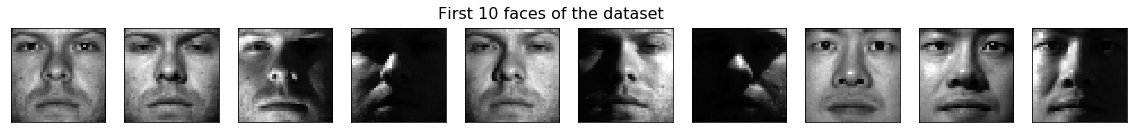

In [3]:
utility.faceGrid(10, V_hat, img_shape)

Next, we will then contaminate the dataset with our noise function. \

<b>AddNoiseToMatrix</b> \
<b>Input Value :</b> Image dataset (numpy array), Noise Type, image shape \
Where we will have the following noise options: 
<ul>
  <li><b>gauss -</b> Inject gaussian noise into the dataset.</li>
  <li><b>s&p -</b> Inject salt & pepper noise into the dataset.</li>
  <li><b>poisson -</b> Inject poisson noise into the dataset.</li>
  <li><b>speckle -</b> Inject speckle noise into the dataset.</li>
  <li><b>block -</b> Inject block occlusion noise into the dataset.</li>
</ul>

<b>Return value :</b> Contaminated dataset, noise mapping (only available in Gaussian noise).

In [4]:
noise_typ = "gauss"
# noise corrupted image and noise mapping (only available for gaussian noise)
V, V_noise = utility.AddNoiseToMatrix(V_hat, noise_typ, img_shape)

In this example we will contiminate the dataset with gaussian noise, we will call the function and display the result in next cell.

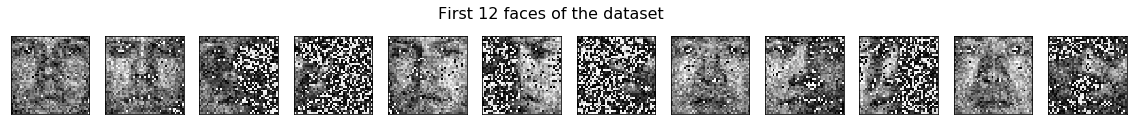

In [5]:
utility.faceGrid(12, V, img_shape)

In this cell, we have defined a two different functions for robustness evaluation. 

We will run our algorithm at least 5 times and calculate accuracy and NMI with subsampling of 90% of the full dataset. Three evaluation metrics is used for during the test.

<b>RelativeReconstructionErrors(RRE):</b> \
let $V$ denote the contaminated dataset(by adding noise), and $\hat{V}$ denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$ , the relative reconstruction errors then can be deﬁned as follows: 

$$ RRE =  \frac{\| \hat{V} - WH \|_F}{\| \hat{V} \|_F} $$

<b>Average Accuracy(RRE):</b> \
Let $W$ and $H$ denote the factorization results on $V$,
$$Acc(Y, Y_{pred}) =  \frac{1}{n} \sum_{i=1}^n \{ Y_{pred}(i) == Y(i) \} $$

<b>Normalized Mutual Information (NMI):</b> \
$$ NMI(Y, Y_{pred}) =  \frac{2 * I (Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$ , where I(· , ·) is mutual information and H(·) is entropy.

In [6]:
def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

# function to run algorithm and record results 
def run(V_hat, Y_hat, noise_type, sub_sample=True, r=5, times=5): 
    print('Starting run with selected Noise selected: ', noise_type)
    V_ssample = V_hat.copy()
    Y_ssample = Y_hat.copy()
    if sub_sample:
        # get 90% sub sample 
        V_ssample, Y_ssample = utility.subsample(V_hat, Y_hat, 0.9, True)
    
    # set initial values before calling the algorithm
    rng  = np.random.RandomState(1)
    n, m = V_ssample.shape
    W0 = rng.rand(n, r)
    H0 = rng.rand(r, m)
    
    RRE = []
    clus_acc = []
    nmi_val = []
    ReconMtx = None
    V = None
    
    # starting for loop
    for i in range(times):
        print("\niteration :", i)
        print("---------------------------")
        
        if sub_sample:
            # get 90% sub sample 
            V_ssample, Y_ssample = utility.subsample(V_hat, Y_hat, 0.9, True)

        noise_typ = noise_type
        V, V_noise = utility.AddNoiseToMatrix(V_ssample, noise_typ, img_shape)

        t0 = datetime.now()
        (wo,ho) = NMF.nmfPG(V, W0, H0, 0.001, 200)
        print("==> Time to compute Matrix Factorization :", (datetime.now() - t0))

        # reconstruct the image block
        ReconMtx = wo.dot(ho)

        # calculate RRE 
        print('==> Calculating RRE ...')
        RRE_val = np.linalg.norm(V_ssample - wo.dot(ho)) / np.linalg.norm(V_ssample)
        RRE.append(RRE_val)

        print('==> Evaluate Acc and NMI ...')

        # Assign cluster labels.
        Y_pred = assign_cluster_label(ho.T, Y_ssample)

        acc = accuracy_score(Y_ssample, Y_pred)
        nmi = normalized_mutual_info_score(Y_ssample, Y_pred)
        clus_acc.append(acc)
        nmi_val.append(nmi)
        print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
        print("---------------------------------------------")

    return V, ReconMtx, RRE, clus_acc, nmi_val

Now we set our sparsity rate and how many times we want to run our algorithm.

For this example, we will set sparsity rate _K_ to 5 and run for 5 times with gaussian noise. 

In [7]:
sub_sample = True
r = 5
times = 5

In [8]:
noise_type = "gauss"

V_sampled, Recon, RRE, ACC, NMI = run(V_hat, Y_hat, noise_type, sub_sample, r, times) 

Starting run with selected Noise selected:  gauss

iteration : 0
---------------------------
==> Time to compute Matrix Factorization : 0:00:03.294115
==> Calculating RRE ...
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.0801 (0.0541)
---------------------------------------------

iteration : 1
---------------------------
==> Time to compute Matrix Factorization : 0:00:02.878157
==> Calculating RRE ...
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.0783 (0.0581)
---------------------------------------------

iteration : 2
---------------------------
==> Time to compute Matrix Factorization : 0:00:02.713809
==> Calculating RRE ...
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.0773 (0.0574)
---------------------------------------------

iteration : 3
---------------------------
==> Time to compute Matrix Factorization : 0:00:02.715010
==> Calculating RRE ...
==> Evaluate Acc and NMI ...
Acc(NMI) = 0.0829 (0.0649)
---------------------------------------------

iteration : 4
---------------------------

Here we can view our result with our defined utility function ResultGrid()

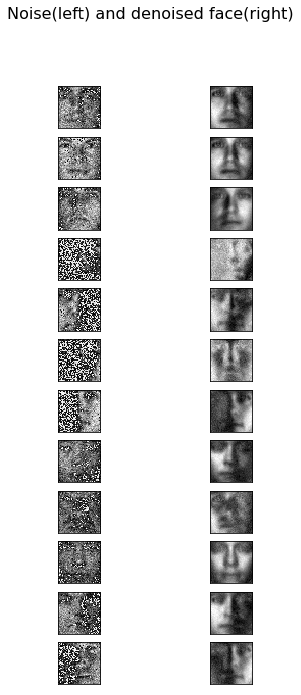

In [13]:
utility.ResultGrid(12, V_sampled, Recon, img_shape)

In [10]:
# set initial values before calling the algorithm
rng = np.random.RandomState(1)
n, m = V_hat.shape
W0 = rng.rand(n, r)
H0 = rng.rand(r, m)

t0 = datetime.now()
(wo,ho) = NMF.nmfPG(V_hat, W0, H0, 0.001, 30)
print("Time to compute Matrix Factorization with Gaussian noise:", (datetime.now() - t0))

# reconstruct the image block
ReconOri = wo.dot(ho)

Time to compute Matrix Factorization with Gaussian noise: 0:00:04.925522


We can also inspect the learned dictionary.

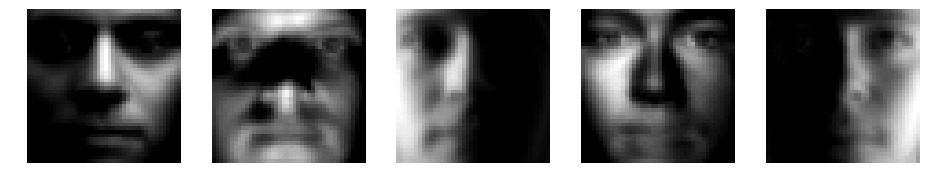

In [11]:
# Inspect learned dictionary
utility.inspect_dictionary(wo, img_shape)